In [1]:
#Necessary imports
import pandas as pd
import numpy as np
import csv
import sqlite3
import matplotlib.pyplot as plt

In [2]:
cd ~drewh\Documents\Flatiron Documents\Phase 1\movie_studio_analysis

C:\Users\drewh\Documents\Flatiron Documents\Phase 1\movie_studio_analysis


In [3]:
#Setting necessary databases to variables, establishing connection and cursor to SQL database
movie_budgets = pd.read_csv("./zippedData/tn.movie_budgets.csv.gz")
con = sqlite3.connect("./zippedData/im.db")
cursor = con.cursor()

In [4]:
#Creates a function to clean columns with money formatted as strings and convert them into integers
movie_budgets["production_budget"]
def clean_money(df, money_column):
    "With input of a dataframe and one of its columns containing an amount of money in string format, removes symbols"
    "and converts strings to integers"
    df[money_column] = df[money_column].str.replace(',','')
    df[money_column] = df[money_column].str.replace('$','')
    df[money_column] = pd.to_numeric(df[money_column])
    return df

#Run function on movie_budgets money columns
movie_budgets = clean_money(movie_budgets,'production_budget')
movie_budgets = clean_money(movie_budgets,'domestic_gross')
movie_budgets = clean_money(movie_budgets,'worldwide_gross')

In [5]:
#Create new "profit" column
movie_budgets["profit"] = movie_budgets["worldwide_gross"] - movie_budgets["production_budget"]

In [6]:
movie_budgets["ROI"] = (movie_budgets["profit"]/movie_budgets["production_budget"]) *100

In [7]:
#Query tables from im.db
persons = pd.read_sql("""
SELECT *
FROM persons
""", con)
writers = pd.read_sql("""
SELECT *
FROM writers
""", con)
films = pd.read_sql("""
SELECT *
FROM movie_basics
""", con)

In [8]:
#Use persons table to link writers to associated movie ids, drop unnecessary columns
full_writers = writers.merge(persons, left_on="person_id", right_on="person_id", how="left")
full_writers.drop(labels=["person_id", "birth_year", "primary_profession"], axis=1, inplace=True)
full_writers = full_writers.rename(columns={"primary_name": "writer_name"})
#Use films table to convert movie IDs into titles, drop unnecessary columns
film_writers = full_writers.merge(films, left_on="movie_id", right_on="movie_id", how="left")
film_writers.drop(labels=["movie_id","genres", "runtime_minutes", "start_year", "original_title"], axis=1, inplace=True)

In [9]:
#Link writers and 
writer_profit = movie_budgets.merge(film_writers, left_on="movie", right_on="primary_title", how="left")
writer_profit.dropna(subset=["writer_name"], inplace=True)

In [10]:
clean_writers = writer_profit.drop_duplicates()

In [11]:
avg_writer_roi = clean_writers.drop_duplicates(subset="movie").mean()["ROI"]

In [12]:
writer_films_strong = clean_writers.drop(clean_writers[clean_writers.ROI < avg_writer_roi].index)
potential_writers = writer_films_strong.drop(writer_films_strong[writer_films_strong["death_year"]>1].index)
writer_pros = dict(potential_writers["writer_name"].value_counts())

In [13]:
writer_films_weak = clean_writers.drop(clean_writers[clean_writers.ROI > avg_writer_roi].index)
questionable_writers = writer_films_weak.drop(writer_films_weak[writer_films_weak["death_year"]>1].index)
writer_cons = dict(questionable_writers["writer_name"].value_counts())

In [14]:
writer_totals = dict(clean_writers["writer_name"].value_counts())

In [15]:
writer_percent = {}
for writer in writer_totals:
    if writer in writer_pros and writer in writer_cons:
        writer_percent[writer] = writer_pros[writer] / writer_totals[writer] * 100
    elif writer in writer_pros and writer not in writer_cons:
        writer_percent[writer] = 100
    elif writer in writer_cons and writer not in writer_pros:
        writer_percent[writer] = 0
    else:
        pass
ranked_writers = dict(sorted(writer_percent.items(), key=lambda x:x[1], reverse=True))
perfect_writers = {}
for key in ranked_writers:
    if ranked_writers[key] == 100:
        perfect_writers[key] = writer_totals[key]

In [16]:
writer_x = list(perfect_writers.keys())[:8]
writer_y = list(perfect_writers.values())[:8]

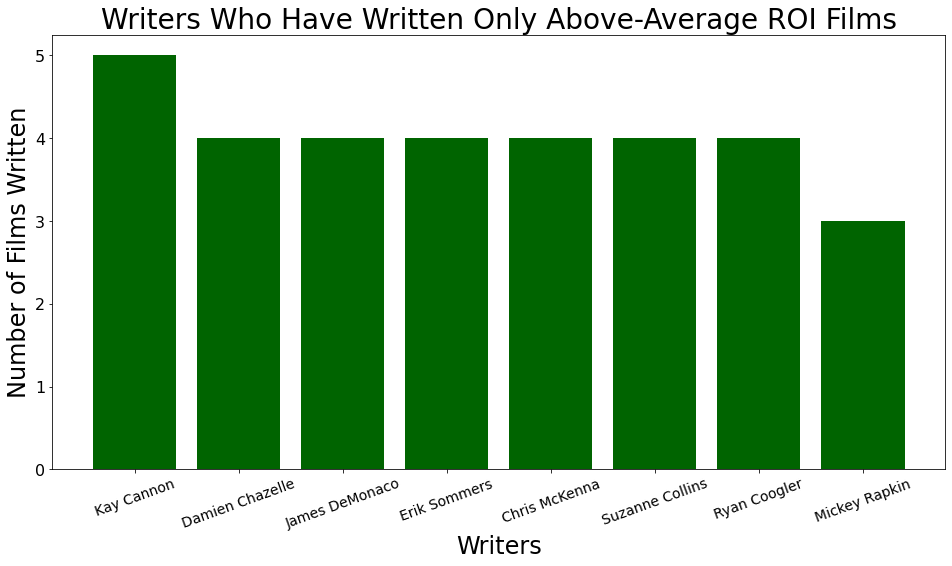

In [17]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.bar(x=writer_x, height=writer_y, color="darkgreen")

ax.set_xlabel('Writers', size=24)
ax.set_ylabel('Number of Films Written', size=24)
ax.set_title('Writers Who Have Written Only Above-Average ROI Films', size=28)
plt.xticks(rotation=20, size=14)
plt.yticks(size=16);

# Directors

In [18]:
directors = pd.read_sql("""
SELECT *
FROM directors
""", con)

In [19]:
full_directors = directors.merge(persons, left_on="person_id", right_on="person_id", how="left")
full_directors.drop(labels=["person_id", "birth_year", "primary_profession"], axis=1, inplace=True)
full_directors = full_directors.rename(columns={"primary_name": "director_name"})

In [20]:
film_directors = full_directors.merge(films, left_on="movie_id", right_on="movie_id",
              how="left")
film_directors.drop(labels=["movie_id","genres", "runtime_minutes", "start_year", "original_title"], axis=1, inplace=True)

In [21]:
dir_profit = movie_budgets.merge(film_directors, left_on="movie", right_on="primary_title", how="left")
dir_profit.dropna(subset=["director_name"], inplace=True)

In [22]:
clean_dir = dir_profit.drop_duplicates()

In [23]:
avg_dir_roi = clean_dir.drop_duplicates(subset="movie").mean()["ROI"]

In [24]:
dir_films_strong = clean_dir.drop(clean_dir[clean_dir.ROI < avg_dir_roi].index)
potential_dir = dir_films_strong.drop(dir_films_strong[dir_films_strong["death_year"]>1].index)
dir_pros = dict(potential_dir["director_name"].value_counts())

In [25]:
dir_films_weak = clean_dir.drop(clean_dir[clean_dir.ROI > avg_dir_roi].index)
questionable_dir = dir_films_weak.drop(dir_films_weak[dir_films_weak["death_year"]>1].index)
dir_cons = dict(questionable_dir["director_name"].value_counts())

In [26]:
dir_totals = dict(clean_dir["director_name"].value_counts())

In [27]:
dir_percent = {}
for _dir in dir_totals:
    if _dir in dir_pros and _dir in dir_cons:
        dir_percent[_dir] = dir_pros[_dir] / dir_totals[_dir] * 100
    elif _dir in dir_pros and _dir not in dir_cons:
        dir_percent[_dir] = 100
    elif _dir in dir_cons and _dir not in dir_pros:
        dir_percent[_dir] = 0
    else:
        pass
ranked_dir = dict(sorted(dir_percent.items(), key=lambda x:x[1], reverse=True))
perfect_dir = {}
for key in ranked_dir:
    if ranked_dir[key] == 100:
        perfect_dir[key] = dir_totals[key]

In [28]:
dir_x = list(perfect_dir.keys())[:8]
dir_y = list(perfect_dir.values())[:8]

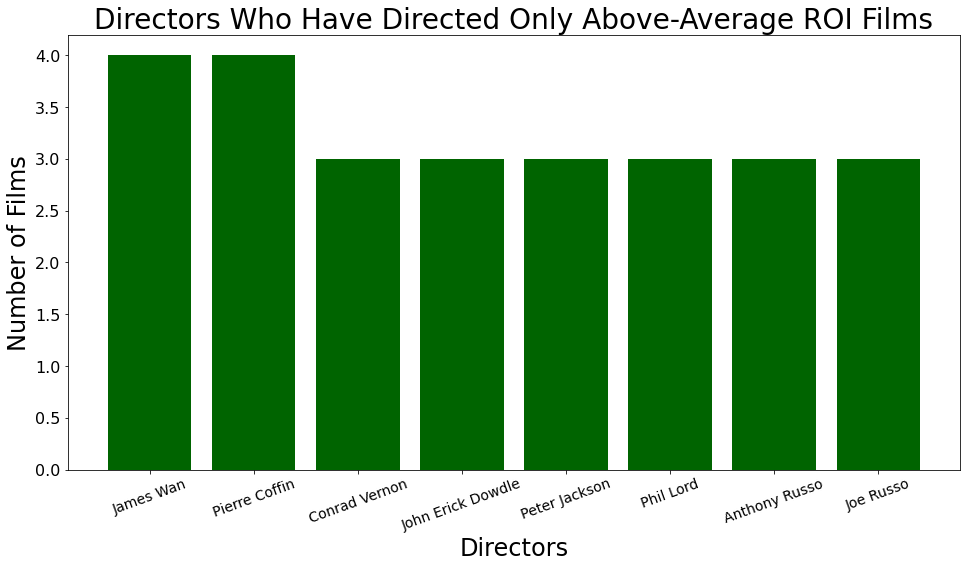

In [29]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.bar(x=dir_x, height=dir_y, color="darkgreen")

ax.set_xlabel('Directors', size=24)
ax.set_ylabel('Number of Films', size=24)
ax.set_title('Directors Who Have Directed Only Above-Average ROI Films', size=28)
plt.xticks(rotation=20, size=14)
plt.yticks(size=16);

# Actors

In [30]:
principals =  pd.read_sql("""
SELECT *
FROM principals
""", con)

In [31]:
actors = principals.drop(principals[(principals.category != "actress")&(principals.category != "actor")].index)
actors.drop(labels=["job", "characters", "ordering", "category"], axis=1, inplace=True)

In [32]:
full_actors = actors.merge(persons, left_on="person_id", right_on="person_id", how="left")
full_actors.drop(labels=["birth_year", "primary_profession"], axis=1, inplace=True)
full_actors = full_actors.rename(columns={"primary_name": "actor_name"})

In [33]:
film_actors = full_actors.merge(films, left_on="movie_id", right_on="movie_id", how="left")
film_actors.drop(labels=["movie_id","genres", "runtime_minutes", "start_year", "original_title"], axis=1, inplace=True)

In [34]:
actor_profit = movie_budgets.merge(film_actors, left_on="movie", right_on="primary_title", how="left")
actor_profit.dropna(subset=["actor_name"], inplace=True)

In [35]:
clean_actors = actor_profit.drop_duplicates()

In [36]:
avg_actor_roi = clean_actors.drop_duplicates(subset="movie").mean()["ROI"]

In [37]:
actor_films_strong = clean_actors.drop(clean_actors[clean_actors.ROI < avg_actor_roi].index)
potential_actors = actor_films_strong.drop(actor_films_strong[actor_films_strong["death_year"]>1].index)
actor_pros = dict(potential_actors["actor_name"].value_counts())

In [38]:
actor_films_weak = clean_actors.drop(clean_actors[clean_actors.ROI > avg_actor_roi].index)
questionable_actors = actor_films_weak.drop(actor_films_weak[actor_films_weak["death_year"]>1].index)
actor_cons = dict(questionable_actors["actor_name"].value_counts())

In [39]:
actor_totals = dict(clean_actors["actor_name"].value_counts())

In [40]:
actor_percent = {}
for actor in actor_totals:
    if actor in actor_pros and actor in actor_cons:
        actor_percent[actor] = actor_pros[actor] / actor_totals[actor] * 100
    elif actor in dir_pros and actor not in dir_cons:
        actor_percent[actor] = 100
    elif actor in dir_cons and actor not in dir_pros:
        actor_percent[actor] = 0
    else:
        pass
ranked_actors = dict(sorted(actor_percent.items(), key=lambda x:x[1], reverse=True))

In [41]:
perfect_actors = {}
for key in ranked_actors:
    if ranked_actors[key] == 100:
        perfect_actors[key] = actor_totals[key]

In [42]:
actor_x = list(perfect_actors.keys())[:8]
actor_y = list(perfect_actors.values())[:8]

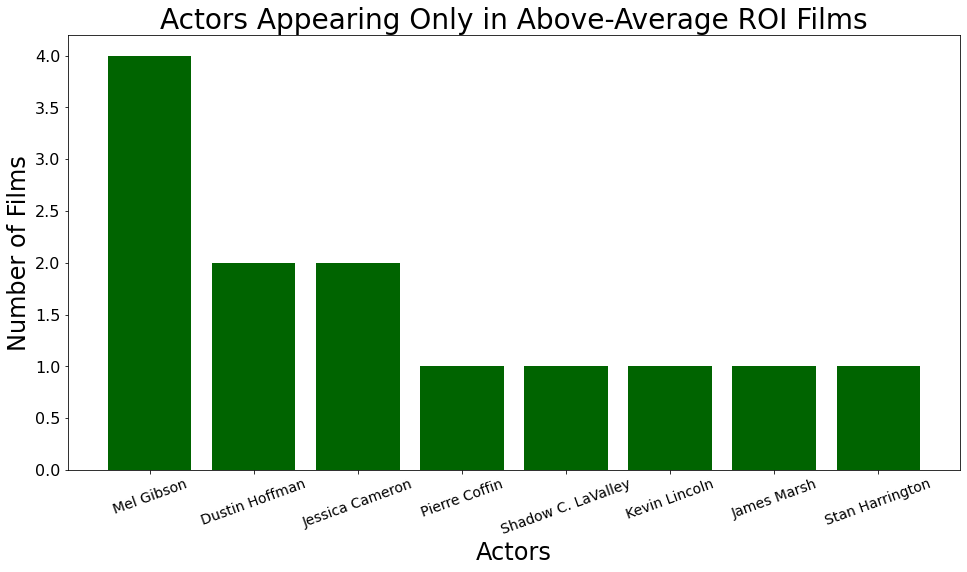

In [43]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.bar(x=actor_x, height=actor_y, color="darkgreen")

ax.set_xlabel('Actors', size=24)
ax.set_ylabel('Number of Films', size=24)
ax.set_title('Actors Appearing Only in Above-Average ROI Films', size=28)
plt.xticks(rotation=20, size=14)
plt.yticks(size=16);

# Synthesis

In [44]:
perc_perf_writers = len(perfect_writers)/len(ranked_writers)*100
perc_perf_dir = len(perfect_dir)/len(ranked_dir)*100
perc_perf_actors = len(perfect_actors)/len(ranked_actors)*100

In [45]:
syn_list_x = ["Writers", "Directors", "Actors"]
syn_list_y = [perc_perf_writers, perc_perf_dir, perc_perf_actors]

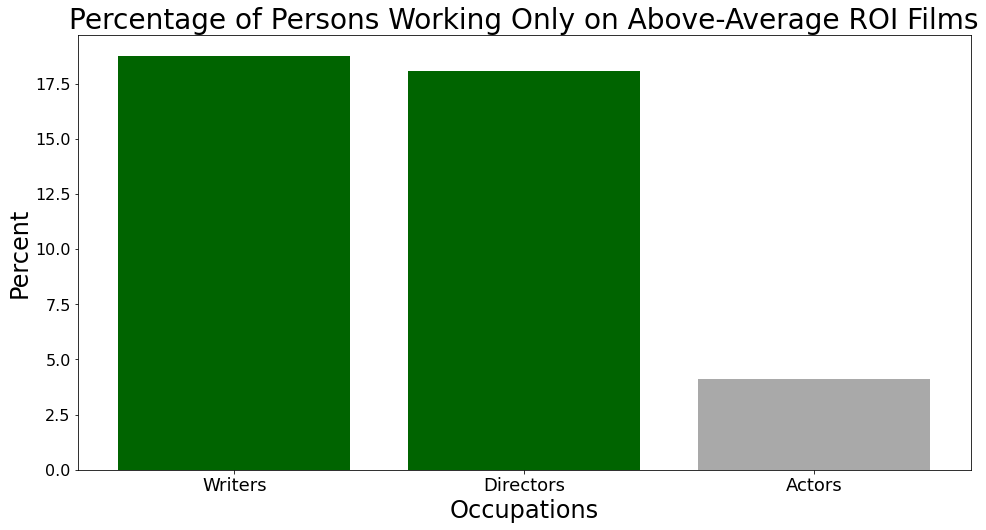

In [46]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.bar(x=syn_list_x, height=syn_list_y, color=["darkgreen", "darkgreen", "darkgrey"])
ax.set_xlabel('Occupations', size=24)
ax.set_ylabel('Percent', size=24)
ax.set_title('Percentage of Persons Working Only on Above-Average ROI Films', size=28)
plt.xticks(size=18)
plt.yticks(size=16);